# Regression Progressive Learner
## Moving Gaussian Experiment
When considering adversarial settings in a progressive learner, it is important to quantify the effects of an adversarial transformer on a progressive learner. In this experiment, we look at the effects of adding multiple transformers and their effects on BTE. We use transformers trained on progressively less adversarial task data as we iterate.

In [26]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage, KNNClassificationDecider, KNNSimpleClassificationDecider
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from joblib import Parallel, delayed
import functions.xor_rxor_with_KNN_functions as fn
from proglearn.sims import generate_gaussian_parity

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

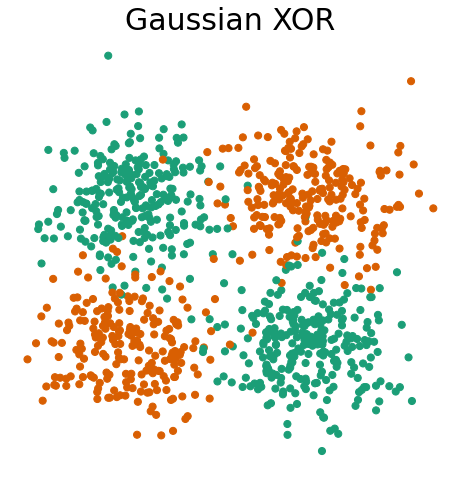

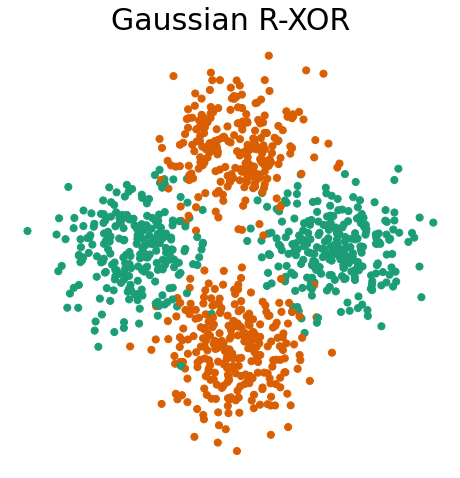

In [2]:
# call function to return gaussian xor and r-xor data:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(1000, angle_params=np.pi/4)

# plot and format:
fn.plot_xor_rxor(X_xor, y_xor, 'Gaussian XOR')
fn.plot_xor_rxor(X_rxor, y_rxor, 'Gaussian R-XOR')

In [3]:
# define hyperparameters:
mc_rep = 100 # 1000 in paper experiment
n_test = 1000 
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

In [41]:
angle_sweep = range(0,46,5)
task1_sample = 1000
task2_sample = 1000
mc_rep = 100
k_neighbors = 5
n_test = 1000
max_depth = 10

In [42]:
# Initiate error arrays
mean_error_bte = np.zeros((k_neighbors, len(angle_sweep)))

# Initiate transfer efficiency arrays
mean_bte = np.zeros((k_neighbors, len(angle_sweep)))

In [43]:
random_state = 0

if task1_sample == 0 and task2_sample == 0:
    raise ValueError("Wake up and provide samples to train!!!")

# If acorn is specified, set random seed to it.
if random_state != None:
    np.random.seed(random_state)

# Initialize array for storing errors, task 1, and task 2.
errors = np.zeros(len(angle_sweep), dtype=float)

# Initialize the transformer type and arguments.
default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

# Initialize the voter type and arguments.
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {"classes" : np.arange(2)}

# Initialize the decider type and arguments.
default_decider_class = SimpleArgmaxAverage
# default_decider_kwargs = {"classes" : np.arange(2), "k" : k_neighbors}
default_decider_kwargs = {"classes" : np.arange(2)}

# Initialize the progressive learner using the transformer, voter and decider classes.
progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class,
                                         default_decider_kwargs = default_decider_kwargs)

# Create the datasets with the Gaussian mean for task 1.
X_task1, y_task1 = generate_gaussian_parity(task1_sample, angle_params=angle_sweep[0])
test_task1, test_label_task1 = generate_gaussian_parity(task1_sample, angle_params=angle_sweep[0])

# Add a task for the task 1, predict the probabilities and add the MSE to the error array.
progressive_learner.add_task(X_task1, y_task1, transformer_voter_decider_split=[0.33, 0.33, 0.33])

l2f_task1 = progressive_learner.predict(test_task1, task_id=0)
errors[0] = np.mean(l2f_task1 == test_label_task1)

# Then, add the transformer trained on task 2, predict and add the MSE to the error array.
for i in range(len(angle_sweep)-1):
    X2,Z2 = generate_gaussian_parity(task2_sample, angle_params=angle_sweep[i+1])
    progressive_learner.add_transformer(X2, Z2)

    predicted_transformer_Z1 = progressive_learner.predict(test_task1, task_id=0)
    errors[i+1] = np.mean(predicted_transformer_Z1 == test_label_task1)

In [68]:
vote_per_transformer_id = []
transformed_per_transformer_id = []
for transformer_id in progressive_learner.task_id_to_decider[0].transformer_id_to_voters_.keys():
    print(transformer_id)
    vote_per_bag_id = []
    transformed_per_bag_id = []
    prediction_per_bag_id = []
    for bag_id in range(len(progressive_learner.task_id_to_decider[0].transformer_id_to_transformers_[transformer_id])):
        transformer = progressive_learner.task_id_to_decider[0].transformer_id_to_transformers_[transformer_id][bag_id]
        X_transformed = transformer.transform(test_task1)
        transformed_per_bag_id.append(X_transformed)
        voter = progressive_learner.task_id_to_decider[0].transformer_id_to_voters_[transformer_id][bag_id]
        vote = voter.predict(X_transformed)
        vote_per_bag_id.append(vote)
    transformed_per_transformer_id.append(np.mean(transformed_per_bag_id, axis=0))
    vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

0
1
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


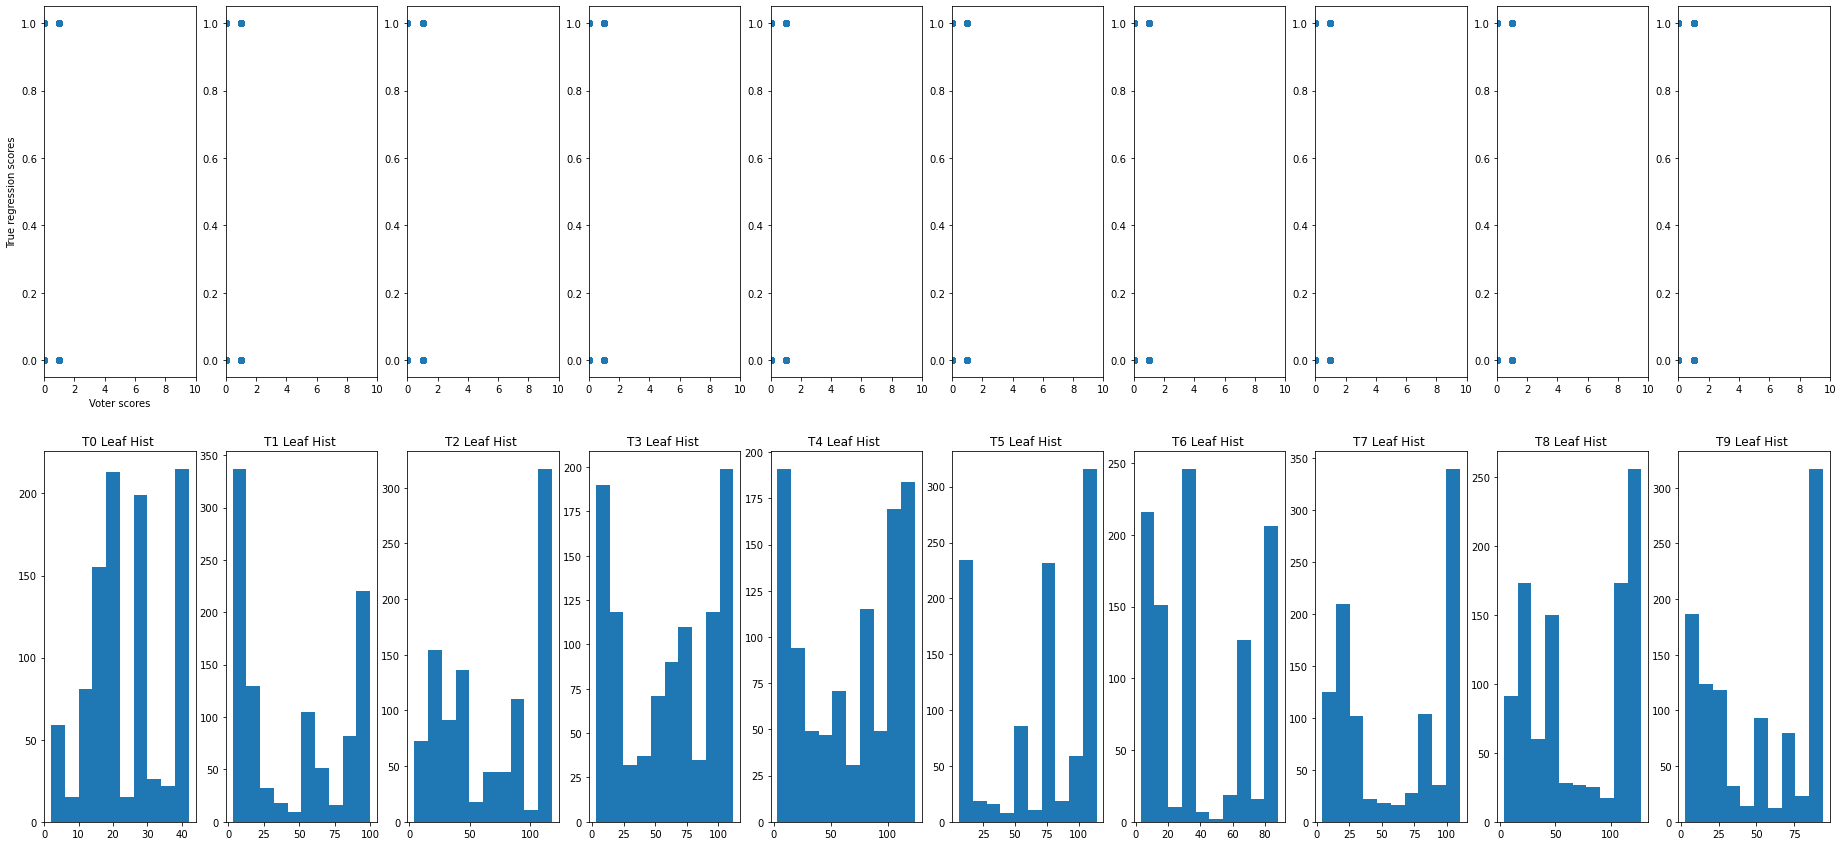

In [71]:
h = 0.05

plt.figure(figsize=(32,15))
r = 2
c = 10

for i in range(r*c):
    if i < c:
        if i == 0:
            ax = plt.subplot(r, c, i+1)
            ax.scatter(vote_per_transformer_id[i], test_label_task1)
#             ax.set_title('T' + str(i) + ' Votes ' + str(means_1))
            ax.set_xlabel('Voter scores')
            ax.set_ylabel('True regression scores')
        elif i > 0:
            ax = plt.subplot(r, c, i+1)
            ax.scatter(vote_per_transformer_id[i], test_label_task1)
#             ax.set_title('T' + str(i) + ' Votes ' + str(means_2[i-1]))
        ax.set_xlim([0,10])
    elif i >= c-1:
        if i == c-1:
            ax = plt.subplot(r, c, i+1)
            print(i-c)
            ax.hist(transformed_per_transformer_id[i-c])
            ax.set_title('T' + str(i-c) + ' Leaf Hist ')
            ax.set_xlabel('Leaf nodes')
            ax.set_ylabel('Count')
        elif i > c-1:
            print(i-c)
            ax = plt.subplot(r, c, i+1)
            ax.hist(transformed_per_transformer_id[i-c])
            ax.set_title('T' + str(i-c) + ' Leaf Hist ')

In [15]:
print(len(np.unique(transformed_per_transformer_id)))
print(errors)

112
[0.527 0.528 0.531 0.547 0.575 0.515 0.528 0.537 0.537 0.552]


C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ipykernel_launcher.py:11: Matplo

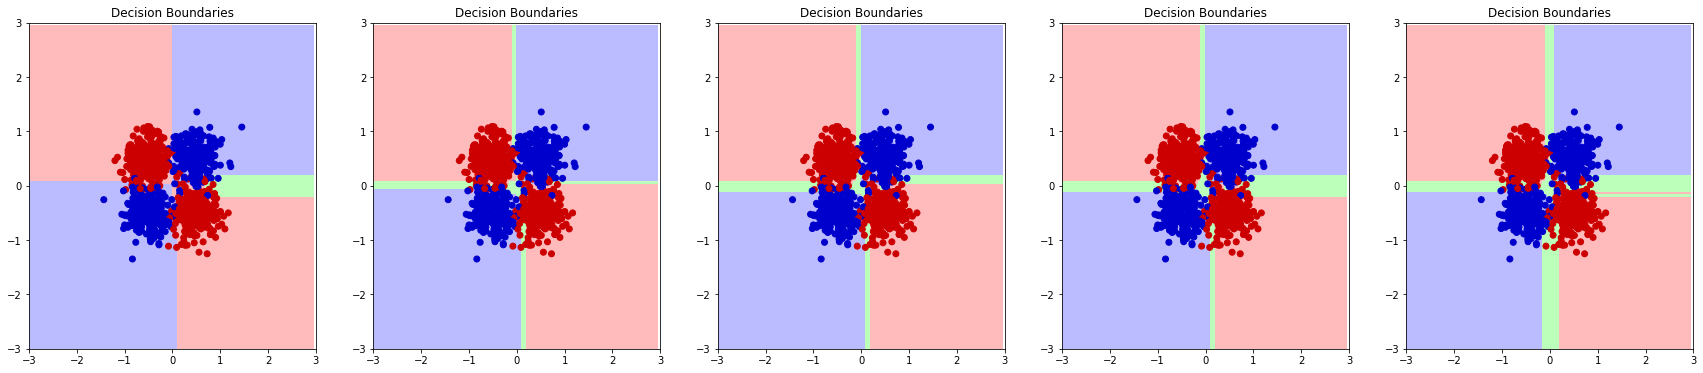

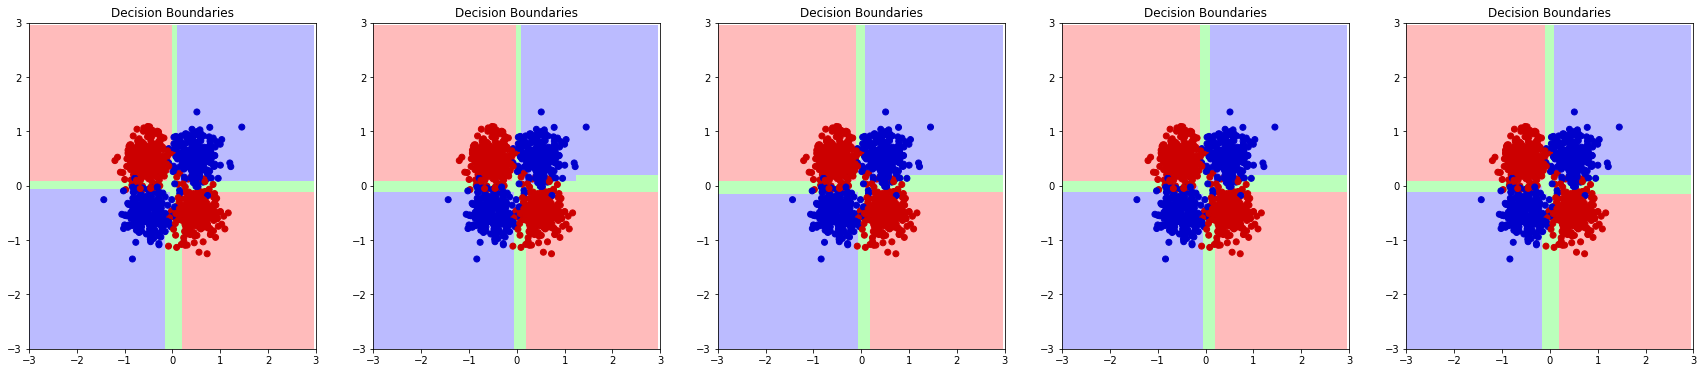

In [93]:
l = 3
h = 0.05 
xx, yy = np.meshgrid(np.arange(-l, l, h), np.arange(-l, l, h))
grid = np.c_[xx.ravel(), yy.ravel()]
plt.figure(figsize=(36,6))
for i in range(1,6,1):
    ran = range(0,i,1)
    z = progressive_learner.task_id_to_decider[0].predict_proba(grid, transformer_ids=ran)[:,1]
    z = z.reshape(xx.shape)
    plt.subplot(1,6,i)
    plt.pcolormesh(xx, yy, z, cmap=cmap_light)
    plt.scatter(test_task1[:,0], test_task1[:,1], c=test_label_task1, cmap=cmap_bold)
    plt.xlim([-l,l]); plt.ylim([-l,l])
    plt.title('Decision Boundaries')

plt.figure(figsize=(36,6))    
for i in range(1,6,1):
    ran = range(0,i+5,1)
    z = progressive_learner.task_id_to_decider[0].predict_proba(grid, transformer_ids=ran)[:,1]
    z = z.reshape(xx.shape)
    plt.subplot(1,6,i)
    plt.pcolormesh(xx, yy, z, cmap=cmap_light)
    plt.scatter(test_task1[:,0], test_task1[:,1], c=test_label_task1, cmap=cmap_bold)
    plt.xlim([-l,l]); plt.ylim([-l,l])
    plt.title('Decision Boundaries')

In [88]:
print(z[0,-2])
print(np.unique(z))

0.9495950993797436
[0.01391564 0.01541328 0.01577509 0.0174267  0.01778851 0.019049
 0.0196067  0.02039897 0.02362478 0.02533624 0.02548868 0.02549731
 0.02603442 0.02695304 0.02751074 0.02913303 0.03046317 0.03264409
 0.03350193 0.03378987 0.03482409 0.03656073 0.03701568 0.03703707
 0.03942531 0.04272813 0.04319445 0.04501436 0.04520787 0.04702605
 0.04824016 0.0506498  0.05413303 0.05572416 0.056549   0.05866958
 0.05882202 0.05943361 0.0671232  0.06722574 0.07034901 0.07193361
 0.07275865 0.07460455 0.07797705 0.07999048 0.081549   0.08180866
 0.08250859 0.08482409 0.08482409 0.08703707 0.08783809 0.08866884
 0.0903453  0.0920457  0.09393565 0.09578748 0.09589713 0.10087162
 0.10203748 0.10211182 0.10744313 0.10788281 0.10825217 0.11162903
 0.11572416 0.1171232  0.11749819 0.119049   0.1196067  0.12559191
 0.12797705 0.12866884 0.12999048 0.13036963 0.13180866 0.13250859
 0.13258262 0.13273506 0.13710455 0.13783809 0.1403453  0.14249819
 0.14393565 0.14437545 0.14578748 0.14935682 